# Overcoming a Theoretical Limitation of Self-Attention 

Replication of experiments on FIRST language learning from [Overcoming a Theoretical Limitation of Self-Attention  (Chiang and Cholak, 2022)](https://arxiv.org/pdf/2202.12172.pdf).

In [17]:
from src.transformer import FirstTransformer
import torch
import pandas as pd

## Learning FIRST

Define training parameters as in the original paper. Citing from (David Chiang and Peter Cholak, 2020):
> We used `d_model` = 16 for word encodings, self-attention, and FFNN outputs, and `d_FFNN` = 64 for FFNN hidden layers. We used layer normalization (ε = 10^−5) after residual connections. We used PyTorch’s default initialization and trained using Adam (Kingma and Ba, 2015) with learning rate 3 × 10^−4 (Karpathy, 2016). We did not use dropout, as it did not seem to help.

In [18]:
log_sigmoid = torch.nn.LogSigmoid()
alphabet = ["0", "1", "$"]

epochs = 20
layers = 2
heads = 1 
d_model = 16 
d_ffnn = 64  
scaled =False # log-length scaled attention
eps = 1e-5 # value added to denominator in layer normalization


Load training data and convert them to Tensor.

In [19]:
train = pd.read_csv("data/first/train.csv")
test = pd.read_csv("data/first/test.csv")

In [20]:
X_train, y_train = train['sequence'].values, train['label'].values
X_test, y_test = test['sequence'].values, test['label'].values

In [21]:
alphabet_index = {a:i for i,a in enumerate(alphabet)}

def _encode(s: str) -> torch.Tensor:
    t = torch.tensor([alphabet_index[c] for c in s])
    return t

X_train = [_encode(s) for s in X_train]
X_test = [_encode(s) for s in X_test]

Initialize the Transformer to learn FIRST.

In [22]:
transformer = FirstTransformer(len(alphabet), layers, heads, d_model, d_ffnn, scaled, eps)
optim = torch.optim.Adam(transformer.parameters(), lr=0.0003)

Training cycle.

In [23]:
train_l = []
val_l = []
train_acc = []
val_acc = []

for epoch in range(epochs):

    train_loss = train_correct = 0    
    
    # train step
    for x, y in zip(X_train, y_train):

        output = transformer(x)

        if not y: output = -output

        if output > 0: train_correct += 1

        loss = -log_sigmoid(output)
        train_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()

    # save statistic about training step
    train_l.append(train_loss) # loss
    train_acc.append(train_correct/len(X_train)) # accuracy
        
    # validation step
    with torch.no_grad():

        test_loss = test_correct = 0

        for x, y in zip(X_test, y_test):

            output = transformer(x)

            if not y: output = -output

            if output > 0: test_correct += 1

            loss = -log_sigmoid(output)
            test_loss += loss.item()

    # save statistic about validation step
    val_l.append(test_loss) # loss
    val_acc.append(test_correct/len(X_test)) # accuracy

    # print step info
    print(f"[Epoch {epoch+1}] --> Train acc: {train_correct/len(X_train)} Train loss: {train_loss}, Test acc: {test_correct/len(X_test)} Test loss: {test_loss}", flush=True)

[Epoch 1] --> Train acc: 0.507 Train loss: 697.7843798100948, Test acc: 0.511 Test loss: 704.918937087059
[Epoch 2] --> Train acc: 0.509 Train loss: 696.3209083080292, Test acc: 0.511 Test loss: 704.008788228035
[Epoch 3] --> Train acc: 0.518 Train loss: 695.5952243804932, Test acc: 0.511 Test loss: 702.9590417146683
[Epoch 4] --> Train acc: 0.523 Train loss: 695.2037618756294, Test acc: 0.511 Test loss: 702.4227955341339
[Epoch 5] --> Train acc: 0.519 Train loss: 694.8604298830032, Test acc: 0.511 Test loss: 701.7184922099113
[Epoch 6] --> Train acc: 0.521 Train loss: 694.6032190322876, Test acc: 0.511 Test loss: 701.3606865406036
[Epoch 7] --> Train acc: 0.52 Train loss: 694.3472517132759, Test acc: 0.511 Test loss: 700.8203113675117
[Epoch 8] --> Train acc: 0.522 Train loss: 694.0822111964226, Test acc: 0.511 Test loss: 700.3326958417892
[Epoch 9] --> Train acc: 0.526 Train loss: 693.8135682344437, Test acc: 0.511 Test loss: 700.1346691846848
[Epoch 10] --> Train acc: 0.526 Train lo

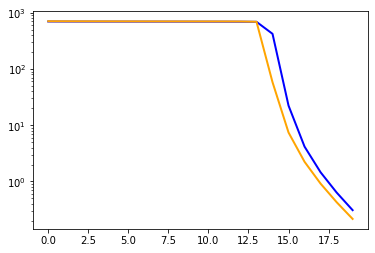

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(epoch+1), train_l, color='blue', lw=2)
plt.plot(range(epoch+1), val_l, color='orange', lw=2)
plt.yscale('log')
plt.show()

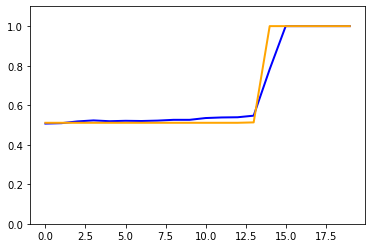

In [25]:
fig = plt.figure()
plt.plot(range(epoch+1), train_acc, color='blue', lw=2)
plt.plot(range(epoch+1), val_acc, color='orange', lw=2)
plt.ylim([0, 1.1])

plt.show()